In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utilities.utils as utils
from openai import OpenAI
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents.agent_toolkits import create_sql_agent
from langchain_astradb import AstraDBVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
import os

load_dotenv()
openaiApiKey = os.getenv("OPENAI_API_KEY")
gptEngine = "gpt-3.5-turbo"
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")

dataSource = "../data/rotten_tomatoes_movies.csv"
df = pd.read_csv(dataSource)
dbEngine = create_engine("sqlite:///movies.db")
df.to_sql("movies", dbEngine, index=False, if_exists='replace')
db = SQLDatabase(engine=dbEngine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.table_info)
print(db.run("Select * from movies"))
# print("Dataframe head analysis \n", df.head())
# print("\n Dataframe null value analysis \n", df.isnull().sum())
# print("\n Unique Directos analysis \n", df['directors'].unique())
# print("\n Dataframe information \n", df.describe())

In [ ]:
# Clean up the data for processing
columns = ['movie_title', 'genres', 'directors', 'tomatometer_rating']
directorDf = utils.clean_dataset(columns, df)

# Get the amount of times a Director appears in the dataset
directorCountDf = directorDf.directors.value_counts().reset_index().rename(columns={"index": "value", 0: "count"})

# Get the amount of directors that appear only once and drop them from directorDf, else get the average rating for each director
for row in directorCountDf.index:
    if directorCountDf['count'][row] <= 1:
        director = directorCountDf['directors'][row]
        directorDf.drop(directorDf[directorDf['directors'] == director].index, inplace=True, axis=0)
        
# Get the average rating for each director that is still in the dataframe
avgRating = utils.get_avg_rating(directorDf)
avgRating.tomatometer_rating = avgRating.tomatometer_rating.round(1)

#Drop directors who have an average rating of 0
for index, row in avgRating.iterrows():
    if (row.tomatometer_rating == 0.0):
        avgRating.drop(avgRating[avgRating.tomatometer_rating == 0.0].index, inplace=True, axis=0)

In [ ]:
# Lets show a plot to show the average ratings for the director(s)
# Lets begin by creating some buckets divisible by 10
bucket0, bucket10, bucket20, bucket30, bucket40, bucket50, bucket60, bucket70, bucket80, bucket90 = ([] for i in range(10))

for index, row in avgRating.iterrows():
    print(row['directors'], row['tomatometer_rating'])
    director = row['directors']
    if row['tomatometer_rating'] < 10:
        bucket0.append(director)
    elif (row['tomatometer_rating'] >= 10) & (row['tomatometer_rating'] < 20):
        bucket10.append(director)
    elif (row['tomatometer_rating'] >= 20) & (row['tomatometer_rating'] < 30):
        bucket20.append(director)
    elif (row['tomatometer_rating'] >= 30) & (row['tomatometer_rating'] < 40):
        bucket30.append(director)
    elif (row['tomatometer_rating'] >= 40) & (row['tomatometer_rating'] < 50):
        bucket40.append(director)
    elif (row['tomatometer_rating'] >= 50) & (row['tomatometer_rating'] < 60):
        bucket50.append(director)
    elif (row['tomatometer_rating'] >= 60) & (row['tomatometer_rating'] < 70):
        bucket60.append(director)
    elif (row['tomatometer_rating'] >= 70) & (row['tomatometer_rating'] < 80):
        bucket70.append(director)
    elif (row['tomatometer_rating'] >= 80) & (row['tomatometer_rating'] < 90):
        bucket80.append(director)
    elif (row['tomatometer_rating'] >= 90) & (row['tomatometer_rating'] <= 100):
        bucket90.append(director)

# print("This is bucket0: \n", bucket0)
# print("\nThis is bucket10: \n", bucket10)
# print("\nThis is bucket10: \n", bucket20)
# print("\nThis is bucket10: \n", bucket30)
# print("\nThis is bucket10: \n", bucket40)
# print("\nThis is bucket10: \n", bucket50)
# print("\nThis is bucket10: \n", bucket60)
# print("\nThis is bucket10: \n", bucket70)
# print("\nThis is bucket10: \n", bucket80)
# print("\nThis is bucket10: \n", bucket90)

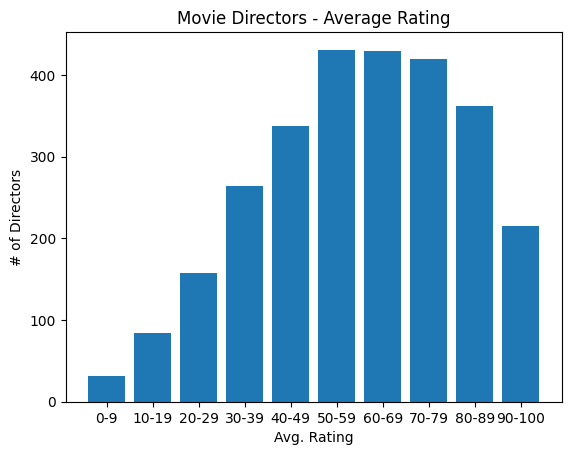

In [42]:
# Create a bar graph using the buckets that have been created above.
# Use the count of how many directors belong to each bucket.
x = np.array(["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-100"])
y = np.array([len(bucket0), len(bucket10), len(bucket20), len(bucket30), len(bucket40), len(bucket50), len(bucket60), len(bucket70), len(bucket80), len(bucket90)])

# Construct the bar graph
plt.title("Movie Directors - Average Rating")
plt.xlabel("Avg. Rating")
plt.ylabel("# of Directors")
plt.bar(x, y)
plt.show()